## Use YOLOv5 with OpenCV to detect cars in videos

In [15]:

import cv2
import torch
from yolov5 import YOLOv5

# Load YOLOv5m model
model = YOLOv5('yolov5m.pt')

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Open video file
video_path = 'dashcamtest.mp4'
cap = cv2.VideoCapture(video_path)

# Check if video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Process video frames
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Perform object detection
    results = model(frame)

    # Draw bounding boxes on the frame
    for result in results.xyxy[0]:
        x1, y1, x2, y2, conf, cls = result
        label = f'{model.names[int(cls)]} {conf:.2f}'
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(frame, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Display the frame
    cv2.imshow('Car Detection', frame)

    # Exit on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release video capture object and close display window
cap.release()
cv2.destroyAllWindows()



WARNING ⚠️ DetectMultiBackend failed: 401 Client Error. (Request ID: Root=1-674e3eab-212b73826078df49276d7ebb;3ef657ba-2dc2-4aec-89aa-31bd55cba693)

Repository Not Found for url: https://huggingface.co/api/models/yolov5m.pt/tree/main?recursive=True&expand=False.
Please make sure you specified the correct `repo_id` and `repo_type`.
If you are trying to access a private or gated repo, make sure you are authenticated.
Invalid username or password.


RepositoryNotFoundError: 401 Client Error. (Request ID: Root=1-674e3eab-00164ed45b79bf127684e656;0f67cb1c-44b5-4307-ba9e-1415b962018d)

Repository Not Found for url: https://huggingface.co/api/models/yolov5m.pt/tree/main?recursive=True&expand=False.
Please make sure you specified the correct `repo_id` and `repo_type`.
If you are trying to access a private or gated repo, make sure you are authenticated.
Invalid username or password.

Using cache found in /Users/herdt/.cache/torch/hub/ultralytics_yolov5_master
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
fatal: cannot change to '/Users/herdt/Library/CloudStorage/OneDrive-UniversityofIowa/Year': No such file or directory
YOLOv5 🚀 2024-11-21 Python-3.12.7 torch-2.5.1 CPU

Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients, 48.9 GFLOPs
Adding AutoShape... 
/Users/herdt/Library/CloudStorage/OneDrive-UniversityofIowa/Year 4/Senior Design/Code/BikeBuddy/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


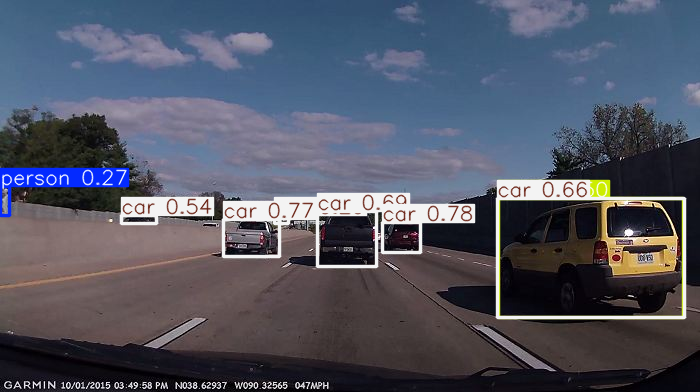

In [9]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5m')

img = 'https://ultralytics.com/images/zidane.jpg'

results = model('dashcamtest2.jpeg')

results.show()

# get bounding box info
bounding_boxes = results.xyxy[0]  # img1 predictions (tensor)

In [10]:
import requests
from PIL import Image
from io import BytesIO

def get_image_size(image_url):
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))
    return img.size

In [11]:
# Convert Bounding Box to Grid Space
def convert_to_grid_space(bounding_box, grid_size, image_width, image_height):
    try:
        x_center = (bounding_box["x_min"] + bounding_box["x_max"]) / 2
        y_center = (bounding_box["y_min"] + bounding_box["y_max"]) / 2
    except KeyError as e:
        raise ValueError(f"Missing key in bounding box data: {e}")

    if not (0 <= x_center <= image_width) or not (0 <= y_center <= image_height):
        raise ValueError("Bounding box coordinates are out of image bounds")

    grid_x = int(x_center / (image_width / grid_size))
    grid_y = int(y_center / (image_height / grid_size))
    
    return grid_x, grid_y

grid_size = 1000
image_width, image_height = get_image_size(img)

for box in bounding_boxes:
    grid_x, grid_y = convert_to_grid_space(box, grid_size, image_width, image_height)
    print(f"In grid space {grid_x}, {grid_y} there is a {box['label']}")

IndexError: too many indices for tensor of dimension 1

In [12]:
# Pass that grid_x grid_y data to an llm to give a text alert to the driver about what is in the image and where it is. Use a local llm

from transformers import pipeline

generator = pipeline('text-generation', model='gpt2')

result = generator("In grid space 1, 2 there is a car", max_length=30, num_return_sequences=1)
print(result)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


[{'generated_text': "In grid space 1, 2 there is a car as well, but that doesn't mean the two vehicles are connected: this is when you need to"}]
